In [1]:
#Simple CNN model for CIFAR-10 dataset
import numpy as np

# Simple CNN model for CIFAR-10
import numpy as np
import os
from keras.datasets import cifar10, cifar100
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras import backend as K

from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

import skimage
from skimage.util import img_as_ubyte
from sklearn.metrics import  ConfusionMatrixDisplay,confusion_matrix,classification_report

In [2]:
#Defining Variables

#Data set information
DATASET = 'cifar-10'
#DATASET = 'cifar-100'
input_shape=(32,32,3)

if DATASET == 'cifar-10':
  num_classes = 10
elif DATASET == 'cifar-100':
  num_classes = 100

#Model Parameters

model_type = 'Alexnet'
#model_type = 'Resnet'
validation_generator=None
epochs = 25
lrate = 0.01
decay = lrate/epochs
batch_size = 32

data_augmentation = True
flow_from_dir = False

subtract_mean = True
seed = 7
np.random.seed(seed)

validate_dir = os.path.join("data","test")
train_dir = os.path.join("data","train")

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')

#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print("Model Type: ",model_type)
print("Model File: ",filepath)

Model Type:  Alexnet
Model File:  /content/saved_models/cifar-10_Alexnet_model.{epoch:03d}.h5


In [3]:
if flow_from_dir:
  if DATASET == 'cifar-10':
    %pip install cifar2png
    %cifar2png cifar10 "data"

170498071/170498071 [==============================] - 13s 0us/step


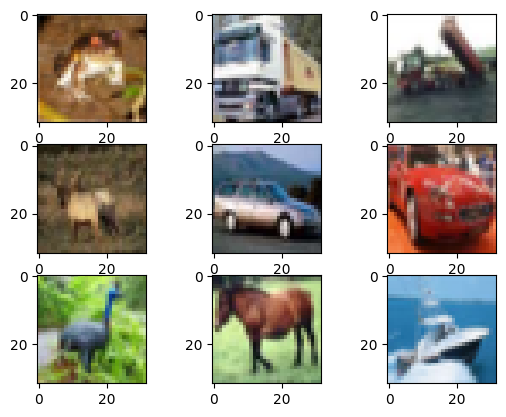

In [4]:
if not flow_from_dir:
  #load data
  if DATASET == 'cifar-10':
    (X_train, y_train),(X_test,y_test) = cifar10.load_data()
    X_train.shape, X_test.shape, X_train.shape[1:],X_train.dtype
  elif DATASET == 'cifar-100':
    (X_train, y_train),(X_test,y_test) = cifar100.load_data()
    X_train.shape, X_test.shape, X_train.shape[1:],X_train.dtype

  #Plot data
  for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(X_train[i])
  plt.show() 
  


In [5]:
def convert_to_imagenet_size(images):
  tmp_images = []
  for image in images:
    image = skimage.transform.resize(image,(224,224),mode='constant')
    image = img_as_ubyte(image)
    tmp_images.append(image)
  return np.array(tmp_images)

In [6]:
#Data Normalization
if not flow_from_dir:
  if not data_augmentation:
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = X_train/255.
    X_test = X_test/255.

    if subtract_mean:
      X_train_mean = np.mean(X_train)
      X_train -= X_train_mean
      X_test_mean = np.mean(X_test)
      X_test -= X_test_mean

  print(y_train.shape, y_test.shape)

(50000, 1) (10000, 1)


In [7]:
if not flow_from_dir:
  y_train = np_utils.to_categorical(y_train)
  y_test = np_utils.to_categorical(y_test)
  print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


In [8]:
#num_classes = y_train.shape[1]
#input_shape=X_train.shape[1:]

input_shape,num_classes

((32, 32, 3), 10)

In [9]:
#Define Alexnet Model
def AlexnetModel(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes,activation='softmax'))

  #model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  #model.summary()
  return model

In [10]:
def get_model(input_shape,num_classes):
  # Create the model - Normal model with CNN, dropouts and MaxPooling.
  # This model gives accuracy of 77% on the test set after 25 epochs

  model = Sequential()

  #model.add(Conv2D(32,(3,3),input_shape=(32,32,3),padding='same',activation='relu'))
  model.add(Conv2D(32,(3,3),input_shape=input_shape,padding='same',activation='relu'))
  model.add(Dropout(0.2))

  model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dropout(0.2))

  model.add(Dense(1024,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(num_classes,activation='softmax'))

  return model



In [11]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [12]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]


In [13]:
#model = get_model(input_shape,num_classes)
if model_type == 'Alexnet':
  #input_shape = (224,224,3)
  model = AlexnetModel(input_shape,num_classes)
else:
  model = get_model(input_shape,num_classes)

# Compile model

#optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss= 'categorical_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
print("Model Summary of ",model_type)
print(model.summary())



Model Summary of  Alexnet
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
if data_augmentation:
	print('Using real-time data augmentation.')
	# This will do preprocessing and realtime data augmentation:
	datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.2,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.2,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).


if not flow_from_dir:
	if not data_augmentation:
		print('Not using data augmentation.')
		history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=callbacks)
	else:   
		print("model using data from downloaded dataset in memoory")
		datagen.fit(X_train)
		# Fit the model on the batches generated by datagen.flow().
		history = model.fit_generator(datagen.flow(X_train, y_train,
                                 batch_size=batch_size),
                                 epochs=epochs,
                                 validation_data=datagen.flow((X_test, y_test),batch_size=batch_size),
                                 workers=4,
                                 callbacks=callbacks)
  
	scores = model.evaluate(X_test, y_test, verbose=1)

else:
	# generator for reading train data from folder

	print('Model fit using flow from directory')


	train_generator = datagen.flow_from_directory(
      train_dir,
      target_size = (224, 224),
      color_mode = 'rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle=False,
      seed=42
      )
	#
	# generator for reading validation data from folder

	validation_generator = datagen.flow_from_directory(
      validate_dir,
      target_size = (224, 224),
      color_mode = 'rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle=False,
      seed=42)
  
	STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
	STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
  
	history = model.fit_generator(generator=train_generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=validation_generator,
                validation_steps=STEP_SIZE_VALID,
                epochs=10,
                callbacks=callbacks
                )
  
	scores = model.evaluate_generator(generator=validation_generator,
                           steps=STEP_SIZE_VALID, verbose=1)

	#Predict the output
	''' Use when to Predict the output
	STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
	test_generator.reset()
	pred=model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

	'''
# Save model and weights



# Score trained model.

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
model using data from downloaded dataset in memoory
Learning rate:  0.001
Epoch 1/25


<ipython-input-14-29bf2adac76f>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train,


1560/1563 [============================>.] - ETA: 0s - loss: 1.8831 - accuracy: 0.2552

1563/1563 [==============================] - 70s 39ms/step - loss: 1.8830 - accuracy: 0.2554 - val_loss: 1.7351 - val_accuracy: 0.3480 - lr: 0.0010
Learning rate:  0.001
Epoch 2/25
1560/1563 [============================>.] - ETA: 0s - loss: 1.6396 - accuracy: 0.3822

1563/1563 [==============================] - 64s 41ms/step - loss: 1.6393 - accuracy: 0.3824 - val_loss: 1.5299 - val_accuracy: 0.4309 - lr: 0.0010
Learning rate:  0.001
Epoch 3/25
1562/1563 [============================>.] - ETA: 0s - loss: 1.5117 - accuracy: 0.4451

1563/1563 [==============================] - 55s 35ms/step - loss: 1.5116 - accuracy: 0.4452 - val_loss: 1.4308 - val_accuracy: 0.4729 - lr: 0.0010
Learning rate:  0.001
Epoch 4/25
1560/1563 [============================>.] - ETA: 0s - loss: 1.4511 - accuracy: 0.4743

1563/1563 [==============================] - 60s 38ms/step - loss: 1.4511 - accuracy: 0.4742 - val_loss: 1.4475 - val_accuracy: 0.4731 - lr: 0.0010
Learning rate:  0.001
Epoch 5/25
1560/1563 [============================>.] - ETA: 0s - loss: 1.4102 - accuracy: 0.4919

1563/1563 [==============================] - 61s 39ms/step - loss: 1.4100 - accuracy: 0.4920 - val_loss: 1.4002 - val_accuracy: 0.4887 - lr: 0.0010
Learning rate:  0.001
Epoch 6/25
1562/1563 [============================>.] - ETA: 0s - loss: 1.3665 - accuracy: 0.5123

1563/1563 [==============================] - 61s 39ms/step - loss: 1.3664 - accuracy: 0.5123 - val_loss: 1.3824 - val_accuracy: 0.4989 - lr: 0.0010
Learning rate:  0.001
Epoch 7/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.3458 - accuracy: 0.5205

1563/1563 [==============================] - 59s 37ms/step - loss: 1.3457 - accuracy: 0.5206 - val_loss: 1.3308 - val_accuracy: 0.5218 - lr: 0.0010
Learning rate:  0.001
Epoch 8/25
1560/1563 [============================>.] - ETA: 0s - loss: 1.3292 - accuracy: 0.5260

1563/1563 [==============================] - 58s 37ms/step - loss: 1.3291 - accuracy: 0.5260 - val_loss: 1.3146 - val_accuracy: 0.5326 - lr: 0.0010
Learning rate:  0.001
Epoch 9/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.3114 - accuracy: 0.5346

1563/1563 [==============================] - 58s 37ms/step - loss: 1.3115 - accuracy: 0.5345 - val_loss: 1.2918 - val_accuracy: 0.5263 - lr: 0.0010
Learning rate:  0.001
Epoch 10/25
1563/1563 [==============================] - ETA: 0s - loss: 1.2944 - accuracy: 0.5416

1563/1563 [==============================] - 62s 39ms/step - loss: 1.2944 - accuracy: 0.5416 - val_loss: 1.3193 - val_accuracy: 0.5205 - lr: 0.0010
Learning rate:  0.001
Epoch 11/25
1563/1563 [==============================] - ETA: 0s - loss: 1.2820 - accuracy: 0.5445

1563/1563 [==============================] - 59s 38ms/step - loss: 1.2820 - accuracy: 0.5445 - val_loss: 1.2706 - val_accuracy: 0.5446 - lr: 0.0010
Learning rate:  0.001
Epoch 12/25
1560/1563 [============================>.] - ETA: 0s - loss: 1.2661 - accuracy: 0.5525

1563/1563 [==============================] - 57s 36ms/step - loss: 1.2663 - accuracy: 0.5524 - val_loss: 1.2592 - val_accuracy: 0.5520 - lr: 0.0010
Learning rate:  0.001
Epoch 13/25
1562/1563 [============================>.] - ETA: 0s - loss: 1.2582 - accuracy: 0.5541

1563/1563 [==============================] - 58s 37ms/step - loss: 1.2585 - accuracy: 0.5540 - val_loss: 1.2345 - val_accuracy: 0.5542 - lr: 0.0010
Learning rate:  0.001
Epoch 14/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.2499 - accuracy: 0.5605

1563/1563 [==============================] - 59s 38ms/step - loss: 1.2497 - accuracy: 0.5605 - val_loss: 1.2268 - val_accuracy: 0.5660 - lr: 0.0010
Learning rate:  0.001
Epoch 15/25
1560/1563 [============================>.] - ETA: 0s - loss: 1.2342 - accuracy: 0.5640

1563/1563 [==============================] - 58s 37ms/step - loss: 1.2345 - accuracy: 0.5639 - val_loss: 1.2630 - val_accuracy: 0.5557 - lr: 0.0010
Learning rate:  0.001
Epoch 16/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.2303 - accuracy: 0.5695

1563/1563 [==============================] - 58s 37ms/step - loss: 1.2304 - accuracy: 0.5696 - val_loss: 1.2409 - val_accuracy: 0.5612 - lr: 0.0010
Learning rate:  0.001
Epoch 17/25
1560/1563 [============================>.] - ETA: 0s - loss: 1.2213 - accuracy: 0.5726

1563/1563 [==============================] - 60s 38ms/step - loss: 1.2213 - accuracy: 0.5726 - val_loss: 1.2163 - val_accuracy: 0.5752 - lr: 0.0010
Learning rate:  0.001
Epoch 18/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.2120 - accuracy: 0.5762

1563/1563 [==============================] - 58s 37ms/step - loss: 1.2118 - accuracy: 0.5762 - val_loss: 1.2288 - val_accuracy: 0.5679 - lr: 0.0010
Learning rate:  0.001
Epoch 19/25
1563/1563 [==============================] - ETA: 0s - loss: 1.2032 - accuracy: 0.5796

1563/1563 [==============================] - 58s 37ms/step - loss: 1.2032 - accuracy: 0.5796 - val_loss: 1.2107 - val_accuracy: 0.5724 - lr: 0.0010
Learning rate:  0.001
Epoch 20/25
1563/1563 [==============================] - ETA: 0s - loss: 1.1917 - accuracy: 0.5822

1563/1563 [==============================] - 61s 39ms/step - loss: 1.1917 - accuracy: 0.5822 - val_loss: 1.2063 - val_accuracy: 0.5758 - lr: 0.0010
Learning rate:  0.001
Epoch 21/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.1964 - accuracy: 0.5843

1563/1563 [==============================] - 59s 38ms/step - loss: 1.1965 - accuracy: 0.5842 - val_loss: 1.1856 - val_accuracy: 0.5805 - lr: 0.0010
Learning rate:  0.001
Epoch 22/25
1563/1563 [==============================] - ETA: 0s - loss: 1.1886 - accuracy: 0.5866

1563/1563 [==============================] - 57s 37ms/step - loss: 1.1886 - accuracy: 0.5866 - val_loss: 1.1952 - val_accuracy: 0.5827 - lr: 0.0010
Learning rate:  0.001
Epoch 23/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.1859 - accuracy: 0.5877

1563/1563 [==============================] - 58s 37ms/step - loss: 1.1860 - accuracy: 0.5876 - val_loss: 1.1626 - val_accuracy: 0.5850 - lr: 0.0010
Learning rate:  0.001
Epoch 24/25
1562/1563 [============================>.] - ETA: 0s - loss: 1.1819 - accuracy: 0.5914

1563/1563 [==============================] - 57s 37ms/step - loss: 1.1818 - accuracy: 0.5914 - val_loss: 1.1760 - val_accuracy: 0.5859 - lr: 0.0010
Learning rate:  0.001
Epoch 25/25
1561/1563 [============================>.] - ETA: 0s - loss: 1.1737 - accuracy: 0.5932

313/313 [==============================] - 2s 4ms/step - loss: 96.8965 - accuracy: 0.2521
Test loss: 96.89653778076172
Test accuracy: 0.25209999084472656


In [15]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 96.89653778076172
Test accuracy: 0.25209999084472656


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


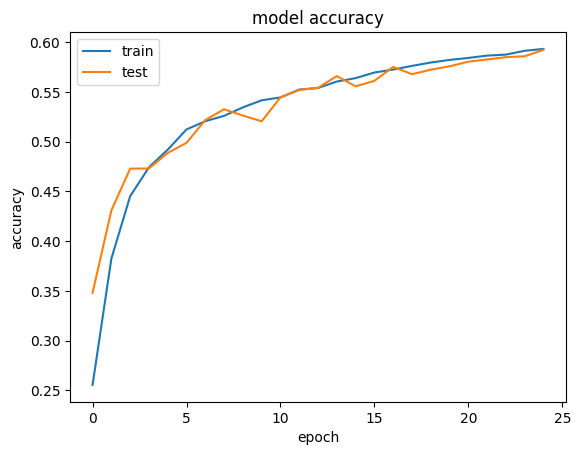

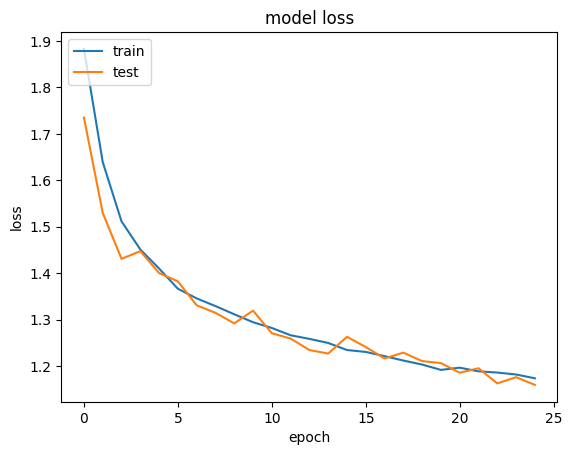

In [16]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
y_pred=model.predict(X_test)
y_preds = y_pred.argmax(axis=1)
y_test2 = y_test.argmax(axis=1)
print(y_preds.shape)
print(y_test2.shape)



313/313 [==============================] - 1s 3ms/step
(10000,)
(10000,)


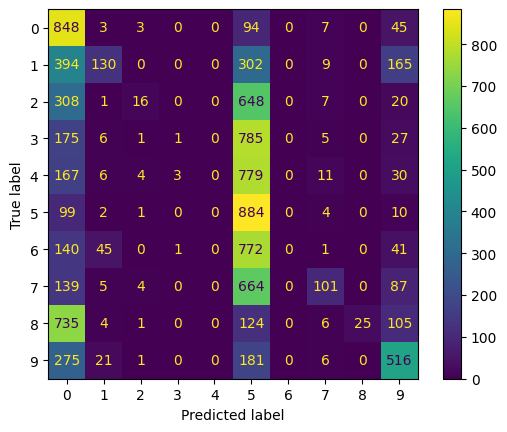

In [22]:
cm = confusion_matrix(y_test2, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_preds))